In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import dill
import matplotlib.pyplot as plt
from scripts import mapcalc_kde

In [3]:
%matplotlib inline

In [4]:
# Boundary conditions for all maps (longitudes as x vals, latitudes as y vals)
lonmin = -76.72
lonmax = -76.52
latmin = 39.19
latmax = 39.38

In [5]:
# load the dilled dataframe
map_df = dill.load(open('dills/map_df_dynamicBW.dill'))

# number of points along each map edge
# (total number of points is npts**2)
npts = np.sqrt(len(map_df))

# generate appropriate lon/lat grid
x = np.linspace(lonmin, lonmax, npts)
y = np.linspace(latmin, latmax, npts)

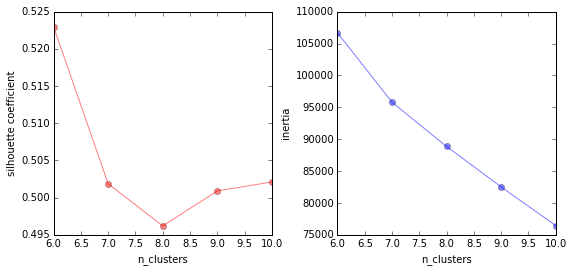

In [12]:
"""
K-means clustering.

First need to determine optimal number of clusters 
using silhouette score and inertia as metrics.

This is slow, so be careful.
"""
X = map_df
n_clusters = range(6,11)
silhouette = [0]*len(n_clusters)
inertia = [0]*len(n_clusters)

# could use GridSearchCV instead, but whatevs...
for i in range(len(n_clusters)):
    model = KMeans(n_clusters=n_clusters[i], n_init=10)
    model.fit(X)
    labels = model.predict(X)
    
    # computing the silhouette score takes time. Scale test set appropriately
    silhouette[i] = silhouette_score(X[::20], labels[::20])
    inertia[i] = model.inertia_

f, (ax1, ax2) = plt.subplots(1,2, figsize=(9,4))
f.subplots_adjust(wspace=0.3)
ax1.set_xlabel('n_clusters')
ax2.set_xlabel('n_clusters')
ax1.set_ylabel('silhouette coefficient')
ax2.set_ylabel('inertia')
ax1.plot(n_clusters, silhouette, 'o-', color='red', alpha=0.5) 
ax2.plot(n_clusters, inertia, 'o-', color='blue', alpha=0.5)

In [13]:
# 7 clusters seems most reasonable.

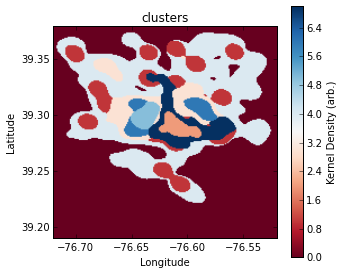

In [14]:
# compute the clusters and data labels
n_clusters = 8
model = KMeans(n_clusters=n_clusters, n_init=20)
model.fit(X)
labels = model.predict(X)

mapcalc_kde.plot_KDE(x, y, labels, 'clusters')

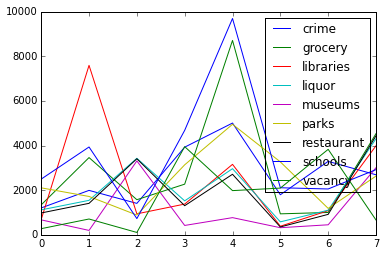

In [15]:
clusters_df = pd.DataFrame(columns=map_df.columns.values)
for i in range(0, n_clusters):
    clusters_df.loc[i] = map_df.iloc[np.argwhere(labels == i).flatten()].sum(axis=0).values
clusters_df.plot()

In [16]:
clusters_df.head()

,crime,grocery,libraries,liquor,museums,parks,restaurant,schools,vacancy
0,1203.788799,1341.173036,683.320328,1117.004784,668.889754,2104.128705,978.313064,2495.338958,274.589564
1,1989.849968,3459.554051,7591.991535,1543.726978,196.347553,1717.618042,1409.627948,3934.319355,707.702828
2,1407.216539,1572.848646,938.720802,3427.611299,3311.300495,885.404182,3407.560000,726.418146,105.408323
3,3926.626835,2268.815742,1376.455827,1520.957626,419.205193,3135.447718,1303.548140,4679.804920,3949.777948
4,5006.632131,8708.978776,3156.529754,2961.970008,769.079936,4951.567098,2711.825885,9692.380554,1979.756865


In [17]:
dill.dump(labels, open('dills/clusters_map.dill', 'wb'))
dill.dump(clusters_df, open('dills/clusters_df.dill', 'wb'))